
# Mask2Face
This notebook will guide you through all the steps described in this article (**TODO: Add link to article**) to build and train your ML model for removing the face mask of the person's face.

**TODO: Add pipeline image**

## 1) Preconditions
First we need a dataset of human faces.

In [1]:
# Check if dataset is already downloaded or needs to be downloaded.
import os
import tarfile
from utils import download_data
from utils.configuration import Configuration

configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if os.path.isdir(dataset_path):
    print('Dataset already downloaded')
else:
    print('Downloading dataset')
    dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
    download_data(configuration.get('dataset_archive_download_url'), dataset_archive_path)
    print('Extracting dataset')
    tar = tarfile.open(dataset_archive_path, 'r:gz')
    tar.extractall('data')
    tar.close()
    print('Done')

Dataset already downloaded


## 2) Data generation
Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

Testing and training data already generated
Here are few examples of generated data.


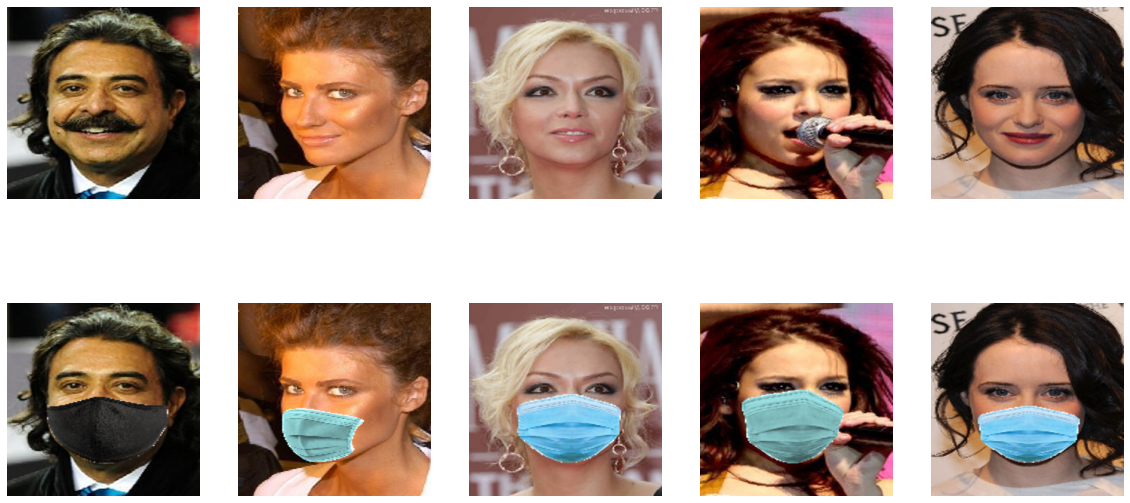

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils.data_generator import DataGenerator

dg = DataGenerator(configuration)

train_folder = configuration.get('train_data_path')
test_folder = configuration.get('test_data_path')

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print('Testing and training data already generated')
else:
    dg.generate_images()

print('Here are few examples of generated data.')
n_examples = 5
inputs, outputs = dg.get_dataset_examples(n_examples)
f, axarr = plt.subplots(2,n_examples, figsize=(20,10))
for i in range(len(inputs)):
    img_in = mpimg.imread(inputs[i])
    img_out = mpimg.imread(outputs[i])
    axarr[1, i].imshow(img_in)
    axarr[1, i].axis('off')
    axarr[0, i].imshow(img_out)
    axarr[0, i].axis('off')

## 3) Model training
Now we have all the data and we can initiate model and start training.

In [3]:
# Import model
from utils.architectures import UNet
from utils.model import Mask2FaceModel

In [4]:
# Feel free to experiment with the number of filters, their sizes or any other parameters
filters = (64, 128, 128, 256, 256, 512)
kernels = ( 7,   7,   7,   3,   3,   3)
input_image_size=(256, 256, 3)
architecture = UNet.RESNET
training_epochs = 20
batch_size = 12

In [5]:
# Create instance of model and start trainig
# TODO: Think about CPU training if GPU is not detected or at least write that you need GPU
model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters, kernels=kernels)
model.summary()
model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

# If you already have pretrained model you can uncomment next line and load it instead of training new one
# model = Mask2FaceModel.load_model('path_to_your_trained_model.h5')

## 4) Results
Our model is trained and we can look at it's performance

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at /home/strv/Projects/mask2face/utils/model.py:158) ]] [Op:__inference_predict_function_6734]

Function call stack:
predict_function


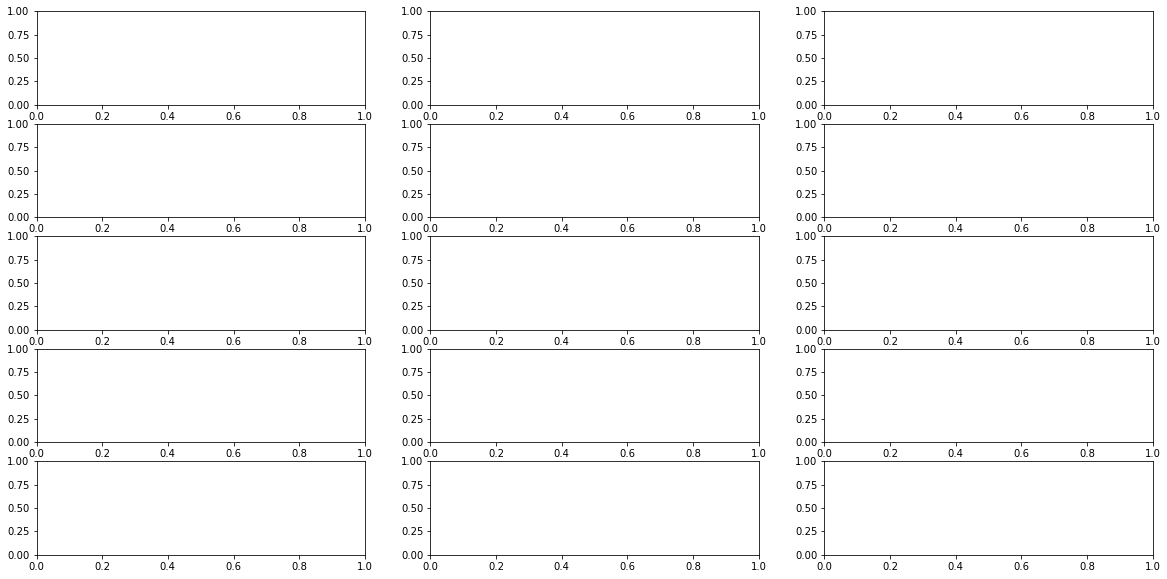

In [6]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=False)
f, axarr = plt.subplots(n_examples, 3, figsize=(20,10))
for i, img in enumerate(input_imgs):
    generated_output = model.predict(img)
    img_in = mpimg.imread(inputs[i])
    img_out = mpimg.imread(outputs[i])
    axarr[i, 0].imshow(input_imgs[i])
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(true_output_imgs[i])
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input image')
axarr[0, 1].set_title('Real output')
axarr[0, 2].set_title('Generated output')